In [1]:
import tensorflow as tf
import keras

from keras import layers
import numpy as np


Using TensorFlow backend.


In [0]:
# ensure consistency across runs
from numpy.random import seed
seed(2)
tf.random.set_seed(2)

# Dataset

In [3]:
#install dependencies
!pip install kaggle

In [4]:
#upload kaggle account credentials
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"bobyuwono","key":"9926919560abed66245d90b2cd8e67ec"}'}

In [5]:
# the kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp  kaggle.json ~/.kaggle/

# this permission change avoids a warning on kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

#import dataset
!kaggle datasets download -d grassknoted/asl-alphabet

!ls

asl-alphabet.zip: Skipping, found more recently modified local copy (use --force to force download)
 asl_alphabet_test    A_test.jpg   D_test.jpg	      kaggle.json   Y_test.jpg
 asl_alphabet_train   B_test.jpg   J_test.jpg	      sample_data
 asl-alphabet.zip     C_test.jpg  'kaggle (1).json'   T_test.jpg


In [6]:
import os
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing191.jpg  
  inflating: asl_alphabet_t

Samples images for letter B


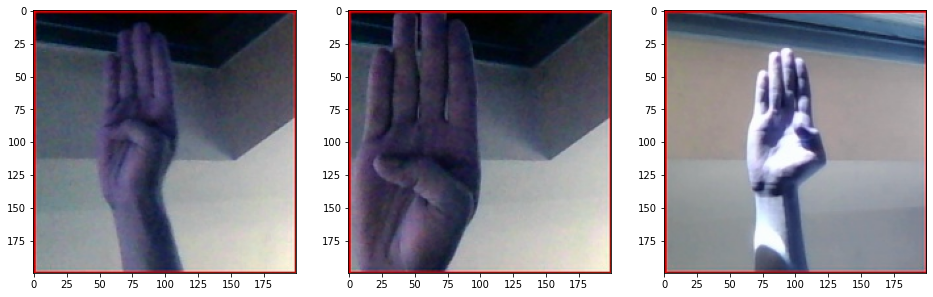

In [7]:
# Imports to view data
import cv2
from glob import glob
from matplotlib import pyplot as plt
from numpy import floor
import random

def plot_three_samples(letter):
    print("Samples images for letter " + letter)
    base_path = 'asl_alphabet_train/asl_alphabet_train/'
    img_path = base_path + letter + '/**'
    path_contents = glob(img_path)
    
    plt.figure(figsize=(16,16))
    imgs = random.sample(path_contents, 3)
    plt.subplot(131)
    plt.imshow(cv2.imread(imgs[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(imgs[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(imgs[2]))
    return

plot_three_samples("B")

In [20]:
from keras.preprocessing.image import ImageDataGenerator

data_dir = "asl_alphabet_train/asl_alphabet_train"
target_size = (60,60)
target_dims = (60,60, 3) # add channel for RGB
n_classes = 29
val_frac = 0.1
batch_size = 64

data_augmentor = ImageDataGenerator(samplewise_center=True, 
                                    samplewise_std_normalization=True, 
                                    validation_split=val_frac)

train_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, shuffle=True, subset="training")
val_generator = data_augmentor.flow_from_directory(data_dir, target_size=target_size, batch_size=batch_size, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


In [0]:
cls_train = train_generator.classes

In [10]:
class_names = list(train_generator.class_indices.keys())
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [11]:
print(cls_train)

[ 0  0  0 ... 28 28 28]


In [12]:
#checking if each class weight is balanced
from sklearn.utils.class_weight import compute_class_weight
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)
class_weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

# Transfer Learning with VGG16 Model

In [13]:
from keras.applications.vgg16 import VGG16

pre_trained_model = VGG16(include_top=False,weights='imagenet', input_shape=(60,60,3))

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 60, 60, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 60, 60, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 60, 60, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 30, 30, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 30, 30, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 30, 30, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 15, 15, 128)       0     

In [14]:
last_layer = pre_trained_model.get_layer('block4_conv3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 512)


In [0]:
from keras import Model
from keras.optimizers import Adam, RMSprop
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(29, activation = 'softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = Adam(lr=1e-7), 
              loss ='categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
history = model.fit_generator(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
1224/1224 [==============================] - 103s 85ms/step - loss: 4.2750 - accuracy: 0.2473 - val_loss: 2.5770 - val_accuracy: 0.3908
Epoch 2/10
1224/1224 [==============================] - 103s 84ms/step - loss: 3.6380 - accuracy: 0.2962 - val_loss: 2.2547 - val_accuracy: 0.4318
Epoch 3/10
1224/1224 [==============================] - 104s 85ms/step - loss: 3.1326 - accuracy: 0.3434 - val_loss: 1.6850 - val_accuracy: 0.4675
Epoch 4/10
1224/1224 [==============================] - 103s 84ms/step - loss: 2.7422 - accuracy: 0.3867 - val_loss: 1.9711 - val_accuracy: 0.4920
Epoch 5/10
1224/1224 [==============================] - 103s 84ms/step - loss: 2.4066 - accuracy: 0.4287 - val_loss: 1.6086 - val_accuracy: 0.5134
Epoch 6/10
1224/1224 [==============================] - 103s 85ms/step - loss: 2.1532 - accuracy: 0.4640 - val_loss: 1.7927 - val_accuracy: 0.5362
Epoch 7/10
1224/1224 [==============================] - 103s 84ms/step - loss: 1.9261 - accuracy: 0.5025 - val_loss: 1

# Predicting session 
belum dicoba*


In [0]:
# upload image to be predicted
from google.colab import files
files.upload()

In [0]:
#helper function to predict
import matplotlib.pyplot as plt
import PIL
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(target_size, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = my_model.predict(img_array)
    print(pred)
    # Decode the output of the VGG16 model.
    # pred_decoded = decode_predictions(pred)[0]

    # # Print the predictions.
    # for code, name, score in pred_decoded:
    #     print("{0:>6.2%} : {1}".format(score, name))

In [0]:
predict(image_path='T_test.jpg')